In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import litellm
import os
import base64
from pathlib import Path
from litellm.caching import Cache
from litellm import completion

In [3]:
from diffusers import AutoencoderKL
import torch

ae = AutoencoderKL.from_pretrained("black-forest-labs/FLUX.1-schnell", torch_dtype=torch.bfloat16, subfolder="vae")

In [4]:
import numpy as np
imgs_path = "120.npz"
nf4 = np.asarray(
    [
        -1.0,
        -0.6961928009986877,
        -0.5250730514526367,
        -0.39491748809814453,
        -0.28444138169288635,
        -0.18477343022823334,
        -0.09105003625154495,
        0.0,
        0.07958029955625534,
        0.16093020141124725,
        0.24611230194568634,
        0.33791524171829224,
        0.44070982933044434,
        0.5626170039176941,
        0.7229568362236023,
        1.0,
    ]
)
latent = np.load(imgs_path)["arr_0"][None]
latent = np.stack((latent & 0x0F, (latent & 0xF0) >> 4), -1).reshape(*latent.shape[:-1], -1)
latent = nf4[latent]
latent = latent * 5.0

In [5]:
def latent_to_img(latent: np.ndarray) -> np.ndarray:
    latent = latent[None]
    latent = np.stack((latent & 0x0F, (latent & 0xF0) >> 4), -1).reshape(*latent.shape[:-1], -1)
    latent = nf4[latent]
    latent = latent * 5.0

    image = ae.decode(z=torch.from_numpy(latent / ae.config.scaling_factor + ae.config.shift_factor).to(torch.bfloat16)).sample
    image_np = ((image + 1) * 127).clip(0, 255).to(torch.uint8).numpy().squeeze().transpose(1, 2, 0)

    return image_np

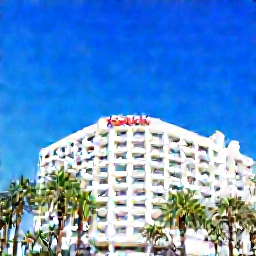

In [6]:
from PIL import Image
image = ae.decode(z=torch.from_numpy(latent / ae.config.scaling_factor + ae.config.shift_factor).to(torch.bfloat16)).sample
image_np = ((image + 1) * 127).clip(0, 255).to(torch.uint8).numpy().squeeze().transpose(1, 2, 0)
image_pil = Image.fromarray(image_np)
image_pil

In [7]:
DISK_CACHE_DIR = Path(".dspy_cache")
DISK_CACHE_LIMIT = 1e10 # 10 GB

litellm.cache = Cache(disk_cache_dir=DISK_CACHE_DIR, type="disk")

if litellm.cache.cache.disk_cache.size_limit != DISK_CACHE_LIMIT:
    litellm.cache.cache.disk_cache.reset("size_limit", DISK_CACHE_LIMIT)

litellm.telemetry = False

# Turn off by default to avoid LiteLLM logging during every LM call.
litellm.suppress_debug_info = True

In [8]:
from PIL import Image
import io

def encode_image(image_pil: Image):
    png_bytes = io.BytesIO()
    image_pil.save(png_bytes, format="PNG")
    return base64.b64encode(png_bytes.getvalue()).decode("utf-8")

base64_image = encode_image(Image.open("cat.jpeg"))
messages = [{
    "role": "user",
    "content": [{
        "type": "text",
        "text": "Describe this image"
    }, {
        "type": "image_url",
        "image_url": {
            "url":  f"data:image/jpeg;base64,{base64_image}"
        }
    }]
}]

In [9]:
response = completion(
  model="openai/google/gemini-2.0-flash-001",
  messages=messages,
  base_url="https://openrouter.ai/api/v1",
)

print(response.choices[0].message.content)

Here is a description of the image:

A captivating square, medium shot depicts an irresistibly charming kitten, poised just above the top of what appears to be a furry or fuzzy container. From the kitten's chest up is visible, with a dark, out-of-focus background behind it.

The kitten's fur is a subtly muted ivory color, giving it a creamy, delicate look. Its eyes, a vivid blue, are the focal point of the photograph, drawing one's attention to the kitten's expressive gaze, directed to the upper right of the frame. The kitten's nose and mouth are shades of a light pink. The whiskers are a light and soft pink. The ears are both pointy.

Below the kitten, the leopard-print base adds texture and pattern to the image. This contrast between the kitten's soft fur and the patterned background creates a visually interesting composition.

Overall, the image evokes a sense of warmth, tenderness, and innocence, capturing the natural beauty and charm of the kitten in a portrait-like setting.


In [10]:
maxacts_folder = Path("flux1-saes") / "maxacts_double_l18_img"

In [11]:
images_folder = maxacts_folder / "images"
image_activations_folder = maxacts_folder / "image_activations"

In [12]:
img_path = images_folder / "51.npz"

img = np.load(img_path, allow_pickle=True)["arr_0"]

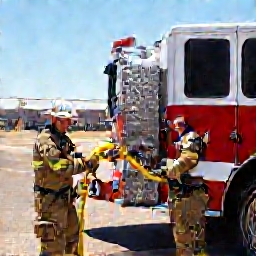

In [13]:
image_pil = Image.fromarray(latent_to_img(img))
image_pil

In [14]:
acts_bd = np.load(maxacts_folder / "feature_acts.db.npy")

In [ ]:
from scored_storage import ScoredStorage

top_k_activations = 1024
scored_storage = ScoredStorage(
    maxacts_folder / "feature_acts.db",
    3, top_k_activations,
    mode="r", use_backup=True
)

2025-02-25 19:22:32.318 | INFO     | scored_storage:__init__:77 - Opening database flux1-saes/maxacts_double_l18_img/feature_acts.db for reading.
2025-02-25 19:22:32.620 | INFO     | scored_storage:__init__:86 - Database flux1-saes/maxacts_double_l18_img/feature_acts.db opened successfully.


In [88]:
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
image_activations_dir = image_activations_folder
HEIGHT, WIDTH = 16, 16

def maxacts(feature_id: int):
    rows = scored_storage.get_rows(feature_id)

    # Group rows by idx
    grouped_rows = {}
    for (idx, h, w), score in rows:
        key = idx
        if key not in grouped_rows:
            grouped_rows[key] = np.zeros((HEIGHT, WIDTH), dtype=float)

        # Add score to the corresponding location in the grid
        grouped_rows[key][h, w] = score

    # Prepare images and cards
    imgs = []
    for idx, grid in sorted(grouped_rows.items(), key=lambda x: x[1].max(), reverse=True):
        try:
            full_activations = np.load(image_activations_dir / f"{idx}.npz")
            loaded_img = np.load(images_folder / f"{idx}.npz", allow_pickle=True)["arr_0"]
        except FileNotFoundError:
            continue
        gravel = grid.ravel()
        k = full_activations["arr_0"].shape[1]
        for i, (f, w) in enumerate(zip(full_activations["arr_0"].ravel(), full_activations["arr_1"].ravel())):
            if f == feature_id:
                gravel[i // k] = w
        if (gravel > 5).sum() < 6:
            continue

        # Normalize the grid for color intensity
        normalized_grid = (grid - grid.min()) / (grid.max() - grid.min()) if grid.max() > grid.min() else grid

        img = latent_to_img(loaded_img)

        fig, ax = plt.subplots()
        ax.imshow(np.asarray(img) / 255, extent=[0, 1, 0, 1])
        grid = ax.imshow(grid, alpha=np.sqrt(normalized_grid) * 0.7, extent=[0, 1, 0, 1], cmap="Blues")
        ax.axis("off")
        fig.colorbar(grid, ax=ax)
        # plt.imshow(normalized_grid, cmap=cmap)
        buf = io.BytesIO()
        fig.savefig(buf)
        buf.seek(0)
        img = Image.open(buf)
        imgs.append(img)
        fig.delaxes(ax)
        fig.clear()
        plt.close(fig)
        del fig
    return imgs

len(maxacts(1934))

6

In [89]:
feat_imgs = maxacts(1934)

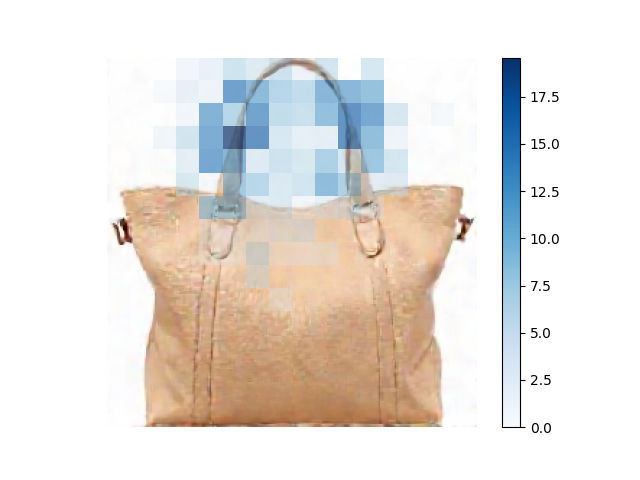

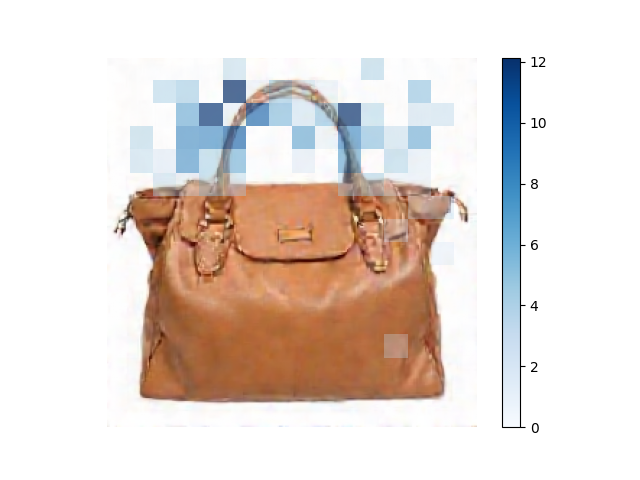

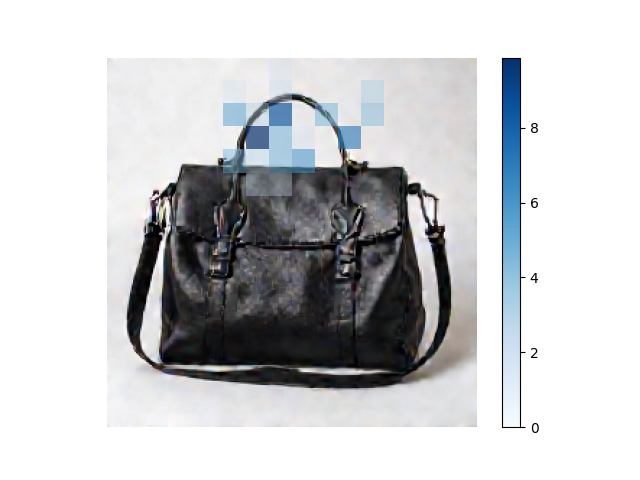

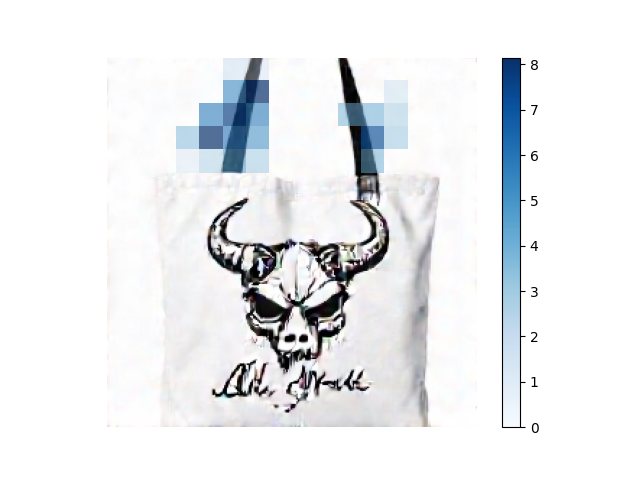

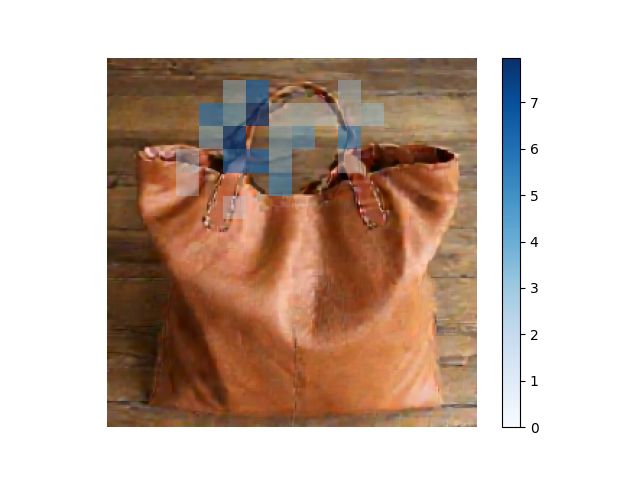

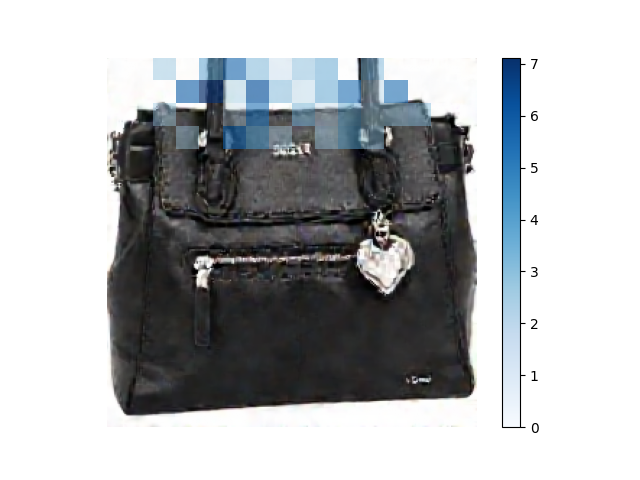

In [90]:
for x in feat_imgs:
    display(x)

In [105]:
from pydantic import BaseModel

activations_template = """You will be given a list of images.
Each image will have activations for a specific neuron highlighted in blue.
You should describe a common pattern or feature that the neuron is capturing.
First, write for each image, which parts are higlighted by the neuron.
Then, write a common pattern or feature that the neuron is capturing.
"""

class ActivationDescription(BaseModel):
    pattern_descriptions: list[str]
    common_pattern: str


def generate_activation_descriptions(images: list) -> str:
    # pil_images = [Image.fromarray(latent_to_img(img)) for img in images]
    pil_images = images
    encoded_images = [encode_image(pil_img) for pil_img in pil_images]

    messages = [{
        "role": "user",
        "content": [{
            "type": "text",
            "text": activations_template
        }]
    }]
    for encoded_image in encoded_images:
        messages.append({
            "role": "user",
            "content": [{
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{encoded_image}"
                }
            }]
        })

    response = completion(
        model="openai/google/gemini-2.0-flash-001",
        messages=messages,
        base_url="https://openrouter.ai/api/v1",
        response_format=ActivationDescription
    )

    return response.choices[0].message.content

In [110]:
import json

judge_template = """You will be given an image. And a neuron's activations description.
The image will have activations for the neuron highlighted in blue.
You should judge whether the description of the neuron's pattern is accurate or not.
Return a score between 0 and 1, where 1 means the description is accurate and 0 means it is not.
"""

class JudgeAnswer(BaseModel):
    score: float

def judge_action_descriptions(images: list, pattern: str) -> float:
    encoded_images = [encode_image(pil_img) for pil_img in images]
    scores = []

    for image in encoded_images:
        messages = [{
            "role": "user",
            "content": [{
                "type": "text",
                "text": judge_template
            }, {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{image}"
                }
            }, {
                "type": "text",
                "text": pattern
            }]
        }]

        response = completion(
            model="openai/google/gemini-2.0-flash-001",
            messages=messages,
            base_url="https://openrouter.ai/api/v1",
            response_format=JudgeAnswer
        )

        score = json.loads(response.choices[0].message.content)["score"]

        scores.append(score)

    return scores

    

In [111]:
import json

descriptions = json.loads(generate_activation_descriptions(feat_imgs))

In [112]:
judge_action_descriptions(feat_imgs, descriptions["common_pattern"])

[1.0, 0.95, 0.9, 1.0, 1.0, 0.9]